## Ultimate, Inc. Coding Challenge
***

In [1]:
# Import Useful Tools for Part 1
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots pretty
sns.set()

# EDA
***

In [2]:
# Load up the data.
df1 = pd.read_json('logins.json', 'r')
df1.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Convert Login Time to a datetime object and add a positive value for each observation.
dftime = pd.DataFrame(pd.to_datetime(df1['login_time']))
dftime['val'] = 1

# Set datetime object as index
dftime = dftime.set_index('login_time')

dftime.head()

,val
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [4]:
# Checking data quality before proceeding
dftime.info()

# No null values and date range appears intact for the index.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
val    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [5]:
def plottime(df, interval, title, y_label='# of Logins'):
    ''' Accepts dataframe, time interval, plot title, and y lable.
    Produces plot of logins based on time interval given.'''
    count = df.resample(interval).count()
    f, ax = plt.subplots(figsize=(10, 3))
    plt.plot(count)
    plt.title(title)
    plt.ylabel(y_label)
    plt.tight_layout()
    
def plotgiven(df, title, y_label='# of Logins'):
    '''Accepts a dataframe, plot title, and y label.  Programe assumes datetime has already been maninuplated.
    Produces plot of logins based on dataframe given.'''
    f, ax = plt.subplots(figsize=(10, 3))
    plt.plot(df)
    plt.title(title)
    plt.ylabel(y_label)
    plt.tight_layout()
    

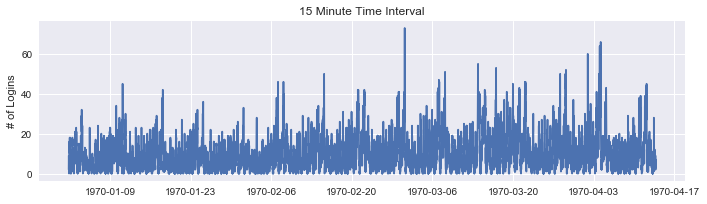

In [6]:
# Plot the 15 Minute Time interval
plottime(dftime,interval='15Min',title='15 Minute Time Interval')
plt.show()

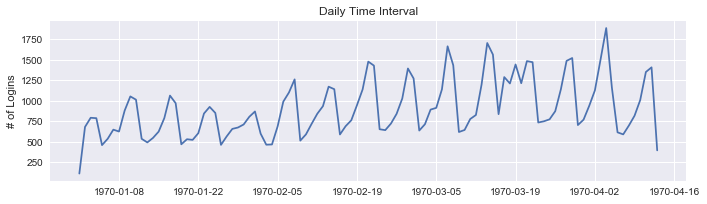

In [7]:
# Plot the daily interval
plottime(dftime,interval='D',title='Daily Time Interval')
plt.show()

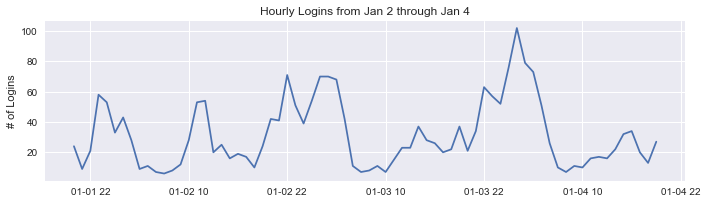

In [8]:
# Plot the hourly logins for a three days (January 2 to January 4)
hour = dftime.resample('60Min').count()
three = hour[:72]
plotgiven(df=three, title='Hourly Logins from Jan 2 through Jan 4')
plt.show()

In [9]:
# Get the Day of the Week for Plotting
df1['weekday'] = pd.to_datetime(df1['login_time']).apply(lambda x: x.weekday())
dfweek = df1.set_index('login_time')
dfweek.head()

,weekday
login_time,
1970-01-01 20:13:18,3
1970-01-01 20:16:10,3
1970-01-01 20:16:37,3
1970-01-01 20:16:36,3
1970-01-01 20:26:21,3


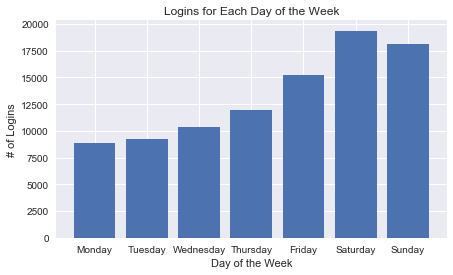

In [10]:
# Instantiate days of the week in a list
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Get the counts of each unique day
day, counts = np.unique(dfweek.weekday, return_counts=True)

# Plot the total counts for each day
f, ax = plt.subplots(figsize=(7, 4))
plt.bar(day, counts)
plt.title('Logins for Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('# of Logins')
plt.xticks(day, days)
plt.show()

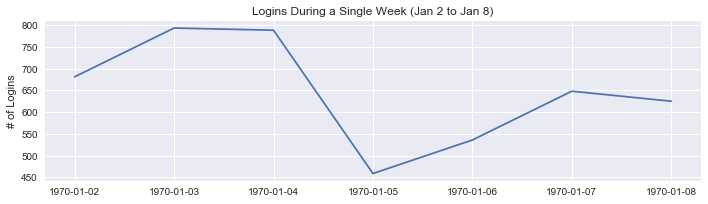

In [11]:
# Plot the daily logins for a single week (January 2 to January 8)
day = dftime.resample('D').count()
week = day[1:8]
plotgiven(df=week, title='Logins During a Single Week (Jan 2 to Jan 8)')
plt.show()

There are three major takeaways from this initial EDA:
-  There has been continued overall growth from January to April.
-  Peak hours are a night, with a bump in logins in the afternoon (around lunch time).
-  Logins rise throughout the week.  They peak during the weekends and trough on Mondays and Tuesdays.

# Experiment and Metric Design
***

**Question 1:** What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?<br><br>
**Answer 1:**  The primary measure of success in this experiment would be the number of intercity trips from one city to another.  The hypothesis of the current experiment is that the toll bridge is the cause of the city exclusivity of driver partners.  As such, reviewing intercity travel as it relates to the implementation of the experiment is the best key measure.  While the number of reimbursement requests would provide an interesting data point, there is nothing to compare them to prior to implementation, and this data point would be best used in follow-up experiments.<br><br><br>
**Question 2:** Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.<br><br>
** Answer 2:A:**  I would implement an A/B experiment where a group of recently active partners were randomly selected from the population.  Of that selection 50% would be given toll reimbursement and the other 50% would act as a control, having to continue to pay for the tolls.<br><br> *Sidenote: Another implementation could contain 33% full reimbursement, 33% half reimbursement, 33% no reimbursement. (This experiment could better evaluate cost-benefit of full reimbursement vs half reimbursement and potentially save Ultimate, Inc. money).* <br><br>
** Answer 2:B:**  I would run a permutation test on the the number of intercity travels for each reimbursement subgroup (full, half, none).  This would output a p-value verifying the null hypothesis or true statistical significance.<br><br>
**Answer 2:C:**  If full and/or half reimbursement where shown to be statistically significant I would then need to review the total number of intercity trips as they compare to each subgroup.  With this data in hand, I would recommend implementing the statistically significant subgroup with the highest intercity trips.  The one caveat I would include is to take cost benefit into consideration.  I.E. the full reimbursement subgroup had the most statistical significance and the highest intercity trip total.  However, the half reimbursement subgroup was still statistically significant and had a intercity trip total that was slightly less than the full reimbursement subgroup's.  As such, it is likely more cost beneficial to implement the slightly weaker model over the strongest model.<br><br>
# Predictive Modeling
***
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.<br><br>
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

In [12]:
# Read in Data
data = json.loads(open('ultimate_data_challenge.json').read())
df2 = pd.DataFrame(data)
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [13]:
# Review each feature
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
# Fill NaN values with Average rating.    Mean seems best fill as 0 is too extreme for this metric.
df2['avg_rating_by_driver'].fillna(df2.avg_rating_by_driver.mean(), inplace=True)
df2['avg_rating_of_driver'].fillna(df2.avg_rating_of_driver.mean(), inplace=True)

# Fill NaN values with string of previous observation for phones. Ffill is was arbitrarily chosen.
# Bfill would be just as good in this instance.
df2['phone'].fillna(method='ffill', inplace=True)

In [15]:
# Get the unique values for cities and phones then create dictionary to map over.
print(df2.city.unique() , df2.phone.unique())
cities = {"King's Landing":1, 'Astapor':2,'Winterfell':3}
phones = {'iPhone':1, 'Android':2}

["King's Landing" 'Astapor' 'Winterfell'] ['iPhone' 'Android']


In [16]:
# Map categorical features to integers.
df2.ultimate_black_user = df2.ultimate_black_user.astype(int)
df2['city'] = df2['city'].map(lambda s: cities[s])
df2['phone'] = df2['phone'].map(lambda s: phones[s])

In [17]:
# Set dates to datetime objects
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])
df2['signup_date'] = pd.to_datetime(df2['signup_date'])

In [18]:
# Create programe to indicate if customer was retained
def retained(last, m_recent):
    '''Takes in the last trip date (last).
    Takes in most recent trip date in the dataframe m(m_recent).
    Subtracts the last trip date from the most recent tirp date date.
    Returns active (1) if calculation is <=30 days
    Returns inactive (0) if calculation is >30 days'''
    if m_recent-last> datetime.timedelta(30):
        return 0
    else:
        return 1
    

In [19]:
# Instantiate active list and most recent date
active = []
m_recent = max(df2['last_trip_date'])
# Cycle through last trip dates and appends active status to list.
for date in df2['last_trip_date']:
    active.append(retained(date, m_recent))

# Adds active feature to the dataframe by making it equal to active list.
df2['active'] = active

In [20]:
# Confirm Data is Clean
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null int64
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: datetime64[ns](2), float64(6), int32(1), int64(4)
memory usage: 4.8 MB


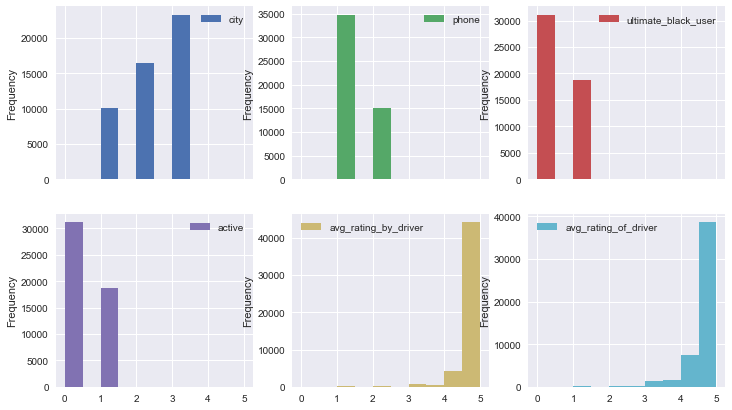

In [21]:
# Plot Categorical features and ratings
df2[['city','phone','ultimate_black_user','active','avg_rating_by_driver',
     'avg_rating_of_driver',]].plot(kind='hist', subplots=True, layout=(2,3),
                                    figsize=(12,7), legend=True)

plt.show()

# cities = "King's Landing":1, 'Astapor':2,'Winterfell':3
# phones = 'iPhone':1, 'Android':2

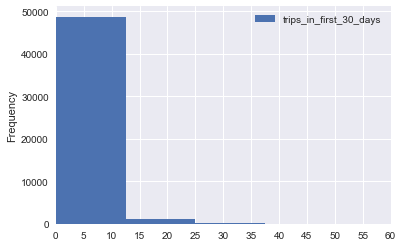

In [22]:
# Plot number of trips in the first 30 days
df2.trips_in_first_30_days.plot(kind='hist', legend=True)
plt.xticks(np.arange(0,65,5))
plt.xlim([0,60])
plt.show()

In [23]:
# Print fraction of retentions after six months
frac = df2.active.sum()/len(df2.active)
print('Percent retained: {0:0.4f}'.format(frac))

Percent retained: 0.3761


In [24]:
# Import necessary tools for prediction
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

In [25]:
# Instantiate X, y, and Xdata objects
y = df2.active.values
X = df2.drop(['active', 'signup_date','last_trip_date'], axis=1).values
Xdata = df2.drop(['active', 'signup_date','last_trip_date'], axis=1)

In [26]:
# Hyperparameter tune Random Forest Classifier.
# Instantiate RandomForestRegressor for hyperparameter tuning.
rfc = RandomForestClassifier(random_state=42)

# Dictionary of hyperparameters to tune.
params_rfc = {
    'max_depth':[1,2,3,4,5,6,7],
    'min_samples_leaf':[.02,.04,.06,.08,.1],
    'max_features':[.2,.4,.6,.8]
}

#Instantiate GridSearch model.
grid_rfc = GridSearchCV(estimator=rfc,
                       param_grid = params_rfc,
                       cv = 5,
                       scoring = 'accuracy',
                       n_jobs=-1)

In [27]:
# Split data.    
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
  
# Fit training data
grid_rfc.fit(X_train,y_train)
    
# Predict on the test set and compute metrics
score = grid_rfc.best_score_
best = grid_rfc.best_estimator_
test_acc = best.score(X_test,y_test)
print('Best Parameters: \n',grid_rfc.best_params_)
print('Best CV Accuracy: {:.3f}'.format(score))
print('Best Test Accuracy: {:.3f}'.format(test_acc), '\n')

Best Parameters: 
 {'max_depth': 4, 'max_features': 0.4, 'min_samples_leaf': 0.02}
Best CV Accuracy: 0.760
Best Test Accuracy: 0.764 



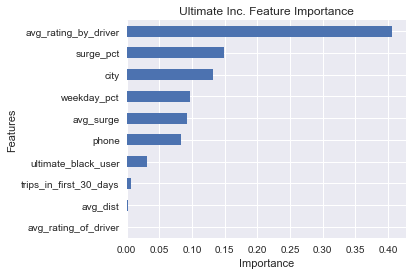

In [28]:
# Plotting important features.
# Instantiate Silver Regressor using hyperparameters from tuning.
rfc= RandomForestClassifier(random_state=42,
                            max_depth=4,
                            max_features=.4,
                            min_samples_leaf=.02,
                            n_jobs=-1)

# Split data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xdata,y, test_size=.3, random_state=42)

# Fit data
rfc.fit(Xd_train,yd_train)

# Get sorted feature importances
importances = pd.Series(rfc.feature_importances_, index=Xdata.columns).sort_values()

#Plot the sorted importances
_ = plt.subplots(1,1, figsize=(5,4))
_ = importances.plot(kind='barh')
_ = plt.title('Ultimate Inc. Feature Importance')
_ = plt.xlabel('Importance')
_ = plt.ylabel('Features')

plt.show()

In [29]:
# Test Adaboost with current best RFC model
# Instantiate AdaBoost model.
adb_rfc = AdaBoostClassifier(base_estimator=rfc, n_estimators=200)

# Fit Data
adb_rfc.fit(X_train,y_train)
train_acc = accuracy_score(y_train, adb_rfc.predict(X_train))
test_acc = accuracy_score(y_test, adb_rfc.predict(X_test))
print('Training Accuracy: {:.3f}'.format(train_acc))
print('Test Accuracy: {:.3f}'.format(test_acc))

Training Accuracy: 0.811
Test Accuracy: 0.787


In [30]:
# Instantiate Regressor, Steps, and Pipeline with Default and SAG Solver
def_log = LogisticRegressionCV(random_state=42, max_iter=400, n_jobs =-1)
sag_log = LogisticRegressionCV(random_state=42, solver='sag', max_iter=400, n_jobs=-1)

# Instantiate Standard Scaler SAG pipeline.
ss_sag_steps = [('scaler',StandardScaler()), ('log',sag_log)]
ss_sag_pipe = Pipeline(ss_sag_steps)

# Instantiate Normalizer scaled SAG pipeline.
n_sag_steps = [('scaler', Normalizer()), ('log', sag_log)]
n_sag_pipe = Pipeline(n_sag_steps)

# Create list of models and their names.
models = [def_log, ss_sag_pipe, n_sag_pipe]
names = ['Default','Scaled SAG','Normal SAG']

In [31]:
#Instantiate placeholder.
place = 0

# Loop over models and get the training and test accuracies for each.
for model in models:
    model.fit(X_train,y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    print(names[place],'Training Accuracy: {0:0.3f}'.format(train_acc))
    print(names[place],'Test Accuracy: {0:0.3f}'.format(test_acc))
    place+=1


Default Training Accuracy: 0.696
Default Test Accuracy: 0.694
Scaled SAG Training Accuracy: 0.695
Scaled SAG Test Accuracy: 0.691
Normal SAG Training Accuracy: 0.686
Normal SAG Test Accuracy: 0.677


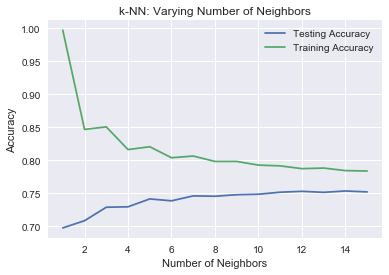

In [32]:
# Hyperparameter tune k-Nearest Neighbors (KNN) model.
# Setup arrays to store train and test accuracies.
neighbors = np.arange(1, 16)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k and produce their training and test accuracies.
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [33]:
# Instantiate KNN with best k, which, based on the above graph, appears to be 12.
knn = KNeighborsClassifier(n_neighbors=12)

# Fit Data
knn.fit(X_train,y_train)
train_acc = accuracy_score(y_train, knn.predict(X_train))
test_acc = accuracy_score(y_test, knn.predict(X_test))
print('Training Accuracy: {:.3f}'.format(train_acc))
print('Test Accuracy: {:.3f}'.format(test_acc))

Training Accuracy: 0.788
Test Accuracy: 0.753


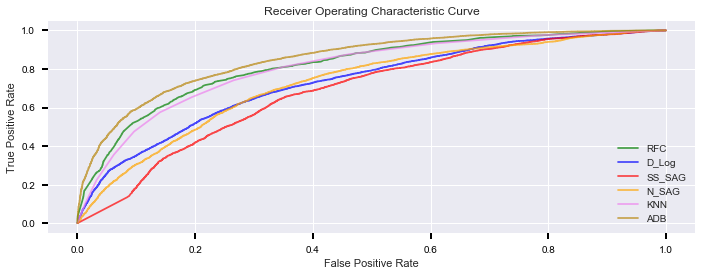

In [34]:
# Set up main figure
fig, ax = plt.subplots(figsize=(10,4))

# Plotting ROC Curve of Classifiers
fpr, tpr, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, label='RFC', color='green', alpha=.7)
fpr1, tpr1, _ = roc_curve(y_test, def_log.predict_proba(X_test)[:, 1])
ax.plot(fpr1, tpr1, label='D_Log', color='blue', alpha=.7)
fpr2, tpr2, _ = roc_curve(y_test, ss_sag_pipe.predict_proba(X_test)[:, 1])
ax.plot(fpr2, tpr2, label='SS_SAG', color='red', alpha=.7)
fpr3, tpr3, _ = roc_curve(y_test, n_sag_pipe.predict_proba(X_test)[:, 1])
ax.plot(fpr3, tpr3, label='N_SAG', color='orange', alpha=.7)
fpr4, tpr4, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
ax.plot(fpr4, tpr4, label='KNN', color='violet', alpha=.7)
fpr5, tpr5, _ = roc_curve(y_test, adb_rfc.predict_proba(X_test)[:, 1])
ax.plot(fpr5, tpr5, label='ADB', color='darkgoldenrod', alpha=.7)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.tick_params(direction='out', length=6, width=2, colors='k')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

**Question:** Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.<br><br>
**Answer:**  Classification using logistic regression and ensemble Classification seemed like the best approach as we had labeled target data of those retained and not retained after 6 months.  Furthermore, the classification models used can be completed fairly quickly, and are not too expensive computationally.  I considered Deep Learning, Ordinary Least Squares with statsmodels, and Naive Bayes as other alternatives to classification via logistic regression and ensemble methods.  My main concern is getting better predictability.  The best model currently produces a test accuracy of 78.7, which, while good, I feel can be improved upon.  Despite this concern, these models are valid.  The key indicator of this validity is the closeness of each model's training accuracy with their test accuracy.  This closeness indicates the models are likely not overfitted or underfitted.<br><br><br>
**Question:** Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm rider retention (again, a few sentences will suffice).<br><br>
**Answer:** Ultimate can leverage the insights of this model in a number of ways.  First Ultimate can further investigate the top features that predict retention, such as: average rating by driver, surge percent, and city.  By understanding how these features predict retention Ultimate can offer targeted incentives or programs that increase the likelihood of retention.  Second, by predicting the likelihood of retention early in a user's use, Ultimate is better able to outreach to and target users with a higher risk of attrition. 